In [1]:
!pip install https://github.com/huggingface/transformers/archive/refs/heads/master.zip
!pip install https://github.com/kensho-technologies/pyctcdecode/archive/refs/heads/main.zip
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install wavio
!pip install jiwer
!pip install arpa
!pip install matplotlib
!pip install librosa

     \ 14.0 MB 6.9 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
You should consider upgrading via the '/Users/kuba/PJATK/semestr3/ZUM/chess-speech-recognition/venv/bin/python -m pip install --upgrade pip' command.
  Using cached https://github.com/kensho-technologies/pyctcdecode/archive/refs/heads/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
You should consider upgrading via the '/Users/kuba/PJATK/semestr3/ZUM/chess-speech-recognition/venv/bin/python -m pip install --upgrade pip' command.
  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/Users/kuba/PJATK/semestr3/ZUM/chess-speech-recognition/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/kuba/PJATK/s

In [53]:
!wget http://users.pja.edu.pl/~danijel/zum/srilm-bin.tar.xz
!tar xvf srilm-bin.tar.xz
!ln -sf ${PWD}/bin/i686-m64/ngram /usr/local/bin/ngram
!ln -sf ${PWD}/bin/i686-m64/ngram-count /usr/local/bin/ngram-count

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.3M  100 35.3M    0     0  3971k      0  0:00:09  0:00:09 --:--:-- 5480k0 --:--:--  0:16:20 40500
x bin/
x bin/merge-batch-counts
x bin/make-batch-counts
x bin/compute-sclite-nbest
x bin/pfsg-from-ngram
x bin/rescore-acoustic
x bin/nbest-error
x bin/search-rover-combo
x bin/rexport.gnumake
x bin/make-multiword-pfsg
x bin/rescore-minimize-wer
x bin/rescore-reweight
x bin/i686-m64/
x bin/i686-m64/sentid-to-sclite
x bin/i686-m64/reverse-lm
x bin/i686-m64/select-vocab
x bin/i686-m64/subset-context-ngrams
x bin/i686-m64/maxalloc
x bin/i686-m64/make-kn-counts
x bin/i686-m64/wlat-to-pfsg
x bin/i686-m64/wlat-stats
x bin/i686-m64/pfsg-vocab
x bin/i686-m64/rover-control-tying
x bin/i686-m64/htklat-vocab
x bin/i686-m64/remove-lowprob-ngrams
x bin/i686-m64/nbest-words
x bin/i686-m64/make-kn-discounts
x bin/i686-m64/get-unigram-probs
x b

In [3]:
!ngram -help

/bin/bash: ngram: command not found


In [6]:
%pylab inline

from pathlib import Path
from tqdm import tqdm

import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from pyctcdecode import build_ctcdecoder
from wavio import read
import jiwer
import arpa
import json

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
processor=Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-10k-voxpopuli-ft-pl')
model=Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-10k-voxpopuli-ft-pl')

In [8]:
%ls -lh ~/.cache/huggingface/hub/models--facebook--wav2vec2-base-10k-voxpopuli-ft-pl/blobs

total 737736
-rw-------  1 kuba  staff   360M Nov 11 22:02 1630e0992935095da6da80d65cc2caa4d7492faea8786d7f2a2f9bca09926329
-rw-------  1 kuba  staff   1.3K Nov 11 22:01 23377f5bfd104ebafd8d83daa32149c88371cc1b
-rw-------  1 kuba  staff    85B Nov 11 22:03 25bc39604f72700b3b8e10bd69bb2f227157edd1
-rw-------  1 kuba  staff   381B Nov 11 22:03 2e0c13460897d00a50a7fa1c524bf1f2fcc152b9
-rw-------  1 kuba  staff   138B Nov 11 22:03 43772fe82c516617b389124d359003795a06ce95
-rw-------  1 kuba  staff   213B Nov 11 22:03 8df8da1de6563b3f11638f4df5f2336f4ca94c04


In [22]:
files={}
for f in Path('./recordings/calls/').glob('*.wav'):
  data=read(str(f))
  files[f.stem]=data.data.squeeze().astype('float32')

In [24]:
Fs=data.rate
for name,d in files.items():
  print(f'{name}: {d.size/Fs:0.2f}s')

gC1: 1.75s
pA1: 1.25s
gE3: 1.50s
kG5: 2.25s
gE6: 1.50s
wB2: 1.50s
wE6: 1.50s


Downsample recordings

In [29]:
import librosa

target_sr=16000
for file in files:
  files[file] = librosa.resample(files[file], orig_sr=Fs, target_sr=target_sr)
Fs = target_sr

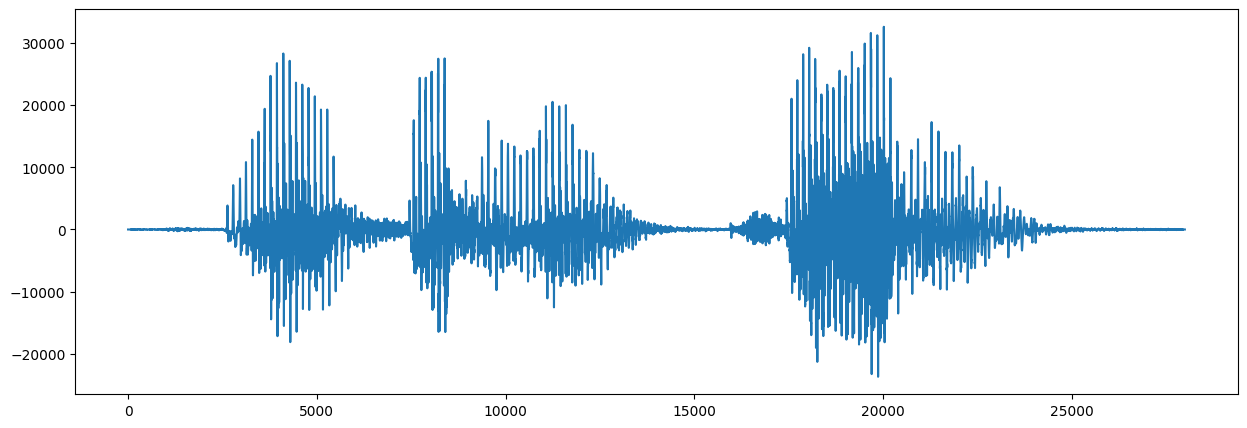

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(list(files.values())[0])

In [33]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True)
  out=model(input_values=feats.input_values)
  predicted_ids=torch.argmax(out.logits,dim=-1)
  sent=processor.batch_decode(predicted_ids)[0]
  trans[name]=sent

100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


In [37]:
assert Fs == 16000

In [38]:
trans

{'gC1': 'ferna cyln',
 'pA1': 'piąnna a jeden',
 'gE3': 'koniecna etrzy',
 'kG5': 'rólna iepięcie',
 'gE6': 'konna esześcia',
 'wB2': 'eranadedwa',
 'wE6': 'jeża na eszeście'}

In [39]:
with open('recordings/calls/text.json') as f:
  ref = json.loads(f.read())

In [40]:
h=[]
r=[]

for name in trans.keys():
  print(f'>>{name}')
  print(trans[name])
  print(ref[name])
  print('')

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

>>gC1
ferna cyln
laufer na c jeden

>>pA1
piąnna a jeden
pion na a jeden

>>gE3
koniecna etrzy
goniec na e trzy

>>kG5
rólna iepięcie
król na g pięć

>>gE6
konna esześcia
koń na e sześć

>>wB2
eranadedwa
wieża na b dwa

>>wE6
jeża na eszeście
wieża na e sześć

{'wer': 0.8928571428571429, 'mer': 0.8928571428571429, 'wil': 0.9785714285714285, 'wip': 0.02142857142857143, 'hits': 3, 'substitutions': 12, 'deletions': 13, 'insertions': 0}


In [45]:
with open('./chess_corpus.json') as f:
  chess_corpus = json.loads(f.read())

In [46]:
chess_calls = []
for figure in chess_corpus['figury']:
  for letter in chess_corpus['litery']:
    for number in chess_corpus['numery']:
      chess_calls.append(f"{figure} na {letter} {number} \n")

In [47]:
with open("chess_corpus.txt", "w") as f:
  f.write("".join([c for c in chess_calls]))

In [48]:
!head -n 10 chess_corpus.txt

goniec na a jeden 
goniec na a dwa 
goniec na a trzy 
goniec na a cztery 
goniec na a pięć 
goniec na a sześć 
goniec na a siedem 
goniec na a osiem 
goniec na a dziewięć 
goniec na b jeden 


In [49]:
!ngram-count -text chess_corpus.txt -order 3 -wbdiscount -unk -lm chess.arpa

/bin/bash: ngram-count: command not found


In [54]:
!ngram -lm chess.arpa -unk -gen 10

/bin/bash: /usr/local/bin/ngram: cannot execute binary file


In [ ]:
tokens=[x[0] for x in sorted(processor.tokenizer.get_vocab().items(),key=lambda x:x[1])]
print(tokens)
tokens[4]=' '
print(tokens)

['<pad>', '<s>', '</s>', '<unk>', '|', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']
['<pad>', '<s>', '</s>', '<unk>', ' ', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']


In [ ]:
decoder=build_ctcdecoder(tokens,'chess.arpa',alpha=2.0,beta=-1.0) # todo adjust alpha, beta

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  sent=decoder.decode(out.logits.cpu().detach().numpy()[0])
  trans[name]=sent

0it [00:00, ?it/s]


In [ ]:
h=[]
r=[]

for name in trans.keys():
  print(f'>>{name}')
  print(trans[name])
  print(ref[name])
  print('')

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

ValueError: ignored